# __Amazon stock price forecasting (AMZN)__

Set working directory to Trading_Recommender folder

In [1]:
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statements

In [2]:
from src.data.extract_dataset import extract_financial_data
from src.features.extend_dataset import compute_technical_indicators, merge_dataframes, get_target
from src.features.feature_selection import select_features, evaluate_features
from src.features.feature_engineering import engineer_features, scale_dataframe, get_final_dataframe
from src.forecast.forecaster import forecaster
from src.forecast.recommender import recommender
from src.tuning.optuna_tuning import optuna_search
import optuna_dashboard
from optuna.storages import JournalStorage, JournalFileStorage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from itertools import accumulate
from copy import deepcopy

Invoking __init__.py for src
Invoking __init__.py for src.data
Invoking __init__.py for src.models
Invoking __init__.py for src.models.LSTM_files
Invoking __init__.py for src.forecast
Invoking __init__.py for src.tuning
Invoking __init__.py for src.features


In [3]:
stock_name = 'AMZN'

Extract the data from locally saved files. There is also an option to download stock market data from yfinance

The raw data that will be used can be classified into three categories:  
1) Stock market data (Open, Close, High, Low, Volume)  
2) SMIS macro-economic indicators (^IXIC, ^GSPC, DJI)  
3) Internet trend data (googletrends, wikipediatrends)  

In [4]:
stock_dict, smis_dict, trend_dict = extract_financial_data(data_dir = 'data', 
                                                           save=False, online=False)
stock = stock_dict[stock_name]
close = stock[['Close']]

Extend the raw features by computing a large number technical indicators using pandas-ta

In [5]:
stock_extended, smis_extended, trend_extended = compute_technical_indicators(stock,
                                                                             deepcopy(smis_dict),
                                                                             deepcopy(trend_dict[stock_name]))

These various types of data will now be merged into only one pandas dataframe

In [6]:
extended_df_withna = merge_dataframes(stock_extended, smis_extended, trend_extended)
extended_df = extended_df_withna.dropna()

Check the number of technical features

In [7]:
print(f'Number of features: {extended_df.shape[1]}')

Number of features: 260


Check the number of rows and the date range

In [8]:
print(f'Number of days: {extended_df.shape[0]}\nDate Range: from {extended_df.index[0]}  to  {extended_df.index[-1]}')

Number of days: 1469
Date Range: from 2020-04-23 00:00:00  to  2024-04-30 00:00:00


Next, a feature selection will be performed using sktime.  
This will be based on whether the selected features are informative enough to predict the binary labels y.  
The labels indicate for each row whether the stock price will be increasing or decreasing {horizon} days into the future

In [9]:
horizon = 14 # How many days ahead do we want to forecast the stock price evolution
target = get_target(extended_df,
                    horizon) # This is the return defined as Close[i+horizon]/Close[i] - 1
y = (target>0).astype(int)

In the next cell, a much smaller number of relevant features are selected

In [10]:
regressor = GradientBoostingRegressor(max_depth=1)
features_selected, feature_importances = select_features(extended_df,
                                                         horizon = horizon,
                                                         n_columns = None,
                                                         regressor = regressor,
                                                         importance_threshold = 0.99)
feature_names = list(features_selected.columns)
# Printing information about the selected features
print(f'Using {regressor = }, only {features_selected.shape[1]} features are selected')
print(f'The selected features with {horizon = } are: \n{feature_names}')
print(f'With a cumulated relative importance of {sum(map(lambda item: item[1], feature_importances))}')

Using regressor = GradientBoostingRegressor(max_depth=1), only 24 features are selected
The selected features with horizon = 14 are: 
['DPO_20', 'OBVe_12', 'ICS_26', 'wikitrends_Amazon.com_FWMA_10', '^IXIC_DPO_20', 'SMIo_5_20_5', 'SUPERT_7_3.0', 'HWL', 'EFI_13', 'ADOSC_3_10', 'J_9_3', 'googletrends_AmazonPrime_news_ALMA_10_6.0_0.85', 'HILO_13_21', '^GSPC_FWMA_10', 'ZS_30', 'BBP_5_2.0', 'googletrends_AmazonPrime_news', 'SMIs_5_20_5', '^IXIC_Open', 'AOBV_LR_2', 'PVO_12_26_9', 'PVOs_12_26_9', 'HWU', 'RSI_14']
With a cumulated relative importance of 1.0000000000000002


The selected features predictive power are evaluated using the Rocket(num_kernels=2000) and HIVECOTEV2(time_limit_in_minutes=0.2) classifier instances

In [11]:
selected_df, _ = get_final_dataframe(features_selected,
                                     target) # Concatenates features_selected with target named as Return, and scales the dataframe
untransformed_result = evaluate_features(selected_df.drop(columns=['Return']), y)
untransformed_accuracies = (untransformed_result['HIVECOTEV2_accuracy'],
                            untransformed_result['Rocket_accuracy'])
print(f'The HIVECOTEV2 and Rocket classifiers respective accuracies using the {features_selected.shape[1]} untransformed features are: {untransformed_accuracies}')

The HIVECOTEV2 and Rocket classifiers respective accuracies using the 24 untransformed features are: (0.7068493150684931, 0.6602739726027397)


In [12]:
for key, value in untransformed_result.items():
    print(f'{key} = {value}')

Rocket_accuracy = 0.6602739726027397
Rocket_precision = 0.546583850931677
Rocket_recall = 0.6330935251798561
Rocket_specificity = 0.6769911504424779
Rocket_f1_score = 0.5866666666666667
Rocket_confusion_matrix = [[153  73]
 [ 51  88]]
HIVECOTEV2_accuracy = 0.7068493150684931
HIVECOTEV2_precision = 0.5879120879120879
HIVECOTEV2_recall = 0.7697841726618705
HIVECOTEV2_specificity = 0.668141592920354
HIVECOTEV2_f1_score = 0.6666666666666666
HIVECOTEV2_confusion_matrix = [[151  75]
 [ 32 107]]


Next, the selected features are transformed using the Principal Component Analysis algorithm  
The engineered features predictive power are evaluated using the Rocket(num_kernels=2000) and HIVECOTEV2(time_limit_in_minutes=0.2) classifier instances

In [13]:
variance_threshold = 0.9
features_engineered, transformer = engineer_features(features_selected, 
                                                     variance_threshold)
engineered_df, scalers = get_final_dataframe(features_engineered,
                                             target) # Concatenates features_engineered with target named as Return, and scales the dataframe
data_scaler, target_scaler = scalers

transformed_result = evaluate_features(engineered_df.drop(columns=['Return']), y)
transformed_accuracies = (transformed_result['HIVECOTEV2_accuracy'],
                          transformed_result['Rocket_accuracy'])
print(f'The HIVECOTEV2 and Rocket classifiers respective accuracies using the {features_engineered.shape[1]} transformed features are: {transformed_accuracies}')


Only 10 features are extracted from the PCA with a total relative variance of 0.9197944891252133/1



C:\ProgramData\anaconda3\Lib\site-packages\sktime\classification\dictionary_based\_tde.py:263: UserWarning: TemporalDictionaryEnsemble warning: min_window = 10 is larger than max_window = 10. min_window has been set to 10.
  warn(


The HIVECOTEV2 and Rocket classifiers respective accuracies using the 10 transformed features are: (0.7863013698630137, 0.7808219178082192)


Despite the fact that the 10 engineered features only reflect about 92% of the variance of the original 24 selected features, the classifiers perform better with these engineered features

In [14]:
for key, value in transformed_result.items():
    print(f'{key} = {value}')

Rocket_accuracy = 0.7808219178082192
Rocket_precision = 0.7565217391304347
Rocket_recall = 0.6258992805755396
Rocket_specificity = 0.8761061946902655
Rocket_f1_score = 0.6850393700787402
Rocket_confusion_matrix = [[198  28]
 [ 52  87]]
HIVECOTEV2_accuracy = 0.7863013698630137
HIVECOTEV2_precision = 0.7798165137614679
HIVECOTEV2_recall = 0.6115107913669064
HIVECOTEV2_specificity = 0.8938053097345132
HIVECOTEV2_f1_score = 0.6854838709677419
HIVECOTEV2_confusion_matrix = [[202  24]
 [ 54  85]]


Next, some information on the engineered features

In [15]:
covariance = transformer.get_covariance()
explained_variance = transformer.explained_variance_/sum(transformer.explained_variance_)
components = transformer.components_[:features_engineered.shape[1], :]
contributions = np.abs(components)/np.sum(np.abs(components), axis = 1, keepdims=True)
contributions_df = pd.DataFrame(contributions, columns=features_selected.columns, index=[f'PC {i+1} (Variance {explained_variance[i]:.4f})' for i in range(components.shape[0])])
contributing_features = [sorted([(contributions_df.columns[i], value) for i, value in enumerate(contributions_df.iloc[j])], key = lambda x:x[1], reverse=True) for j in range(contributions_df.shape[0])]

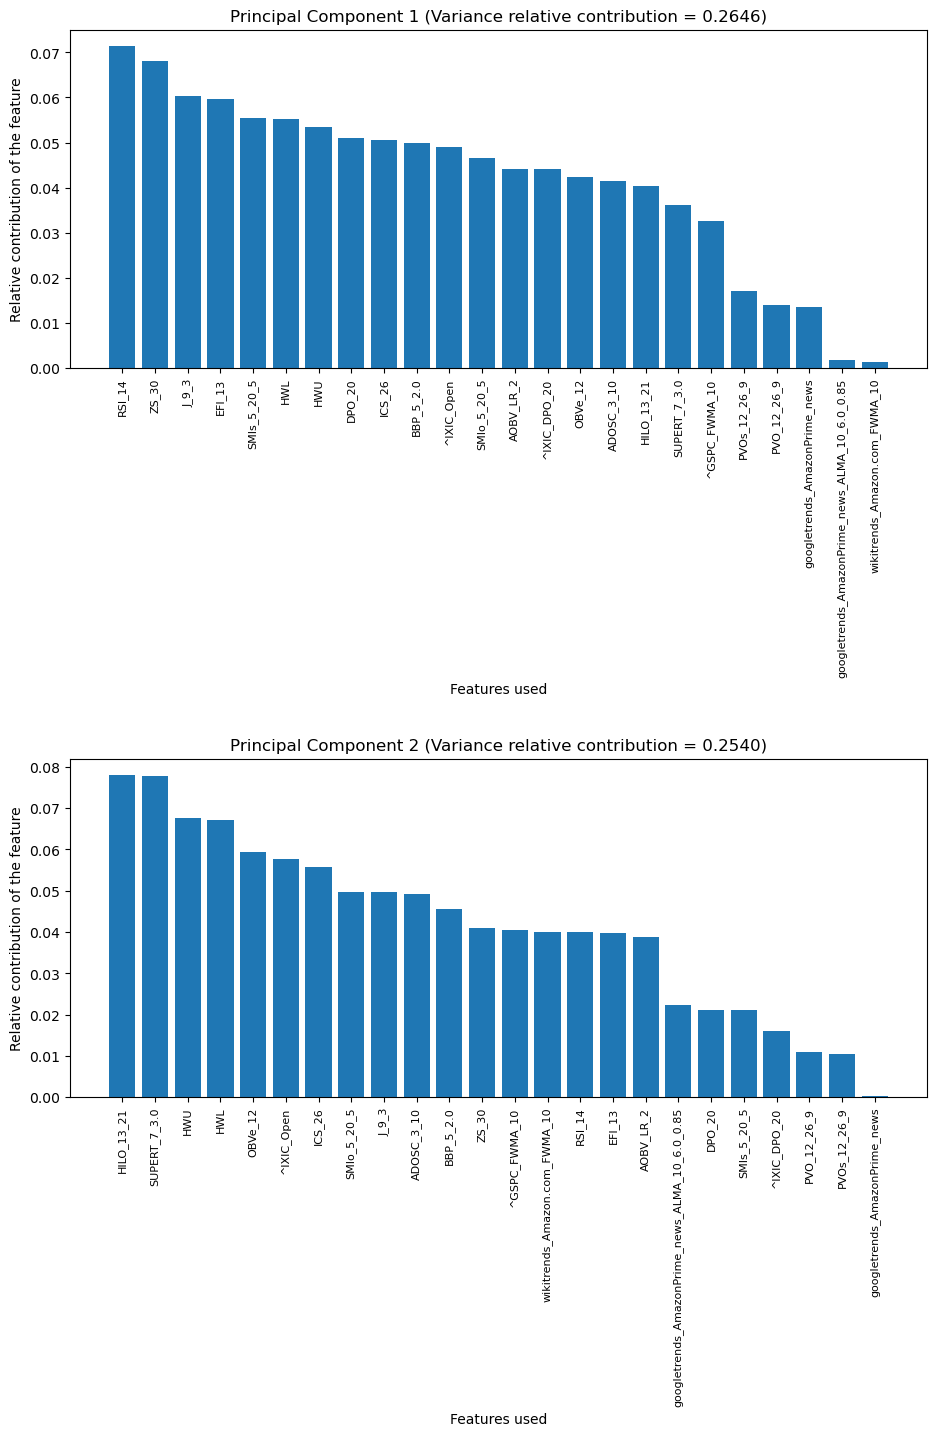

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))

for i, component in enumerate(contributing_features[:2]):
    features = [x[0] for x in component]
    values = [x[1] for x in component]

    axs[i].bar(features, values)
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].set_title(f'Principal Component {i+1} (Variance relative contribution = {explained_variance[i]:.4f})')
    axs[i].set_xlabel('Features used')
    axs[i].set_ylabel('Relative contribution of the feature')

plt.tight_layout(pad=3)
plt.show()

It can be noted that: 
- The two main Principal Components hold more than half of the total variance
- Some SMIS macroeconomic indicators (^IXIC, ^GSPC) contribute significantly to the two main Principal Components
- Statistics on searched keywords like Amazon and AmazonPrime on Google and Wikipedia also contribute to the two main Principal Components

In [17]:
engineered_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Return
DateTime,,,,,,,,,,,
2020-04-23,0.018269,-2.102672,-1.315566,-0.783344,2.092256,-1.243143,-0.309707,0.067550,-1.223571,0.889124,-0.295527
2020-04-24,-0.028284,-2.073452,-1.401482,-0.550790,1.897711,-1.343339,-0.268056,-0.279432,-1.121322,0.908106,-0.286885
2020-04-25,0.078350,-1.968605,-1.448871,-0.567636,1.802195,-1.422988,-0.309274,-0.407626,-1.114366,1.040429,-0.153696
2020-04-26,0.185007,-1.863105,-1.494765,-0.582166,1.706889,-1.503923,-0.350886,-0.530041,-1.109630,1.173770,-0.019233
2020-04-27,0.288089,-1.750368,-1.542374,-0.557310,1.651529,-1.554348,-0.274497,-0.537465,-1.121372,1.376312,0.116520


In [18]:
engineered_df.tail()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Return
DateTime,,,,,,,,,,,
2024-04-12,-1.765575,0.940279,0.251830,-0.596037,-1.064923,-0.316902,-0.260849,-0.901581,0.909612,0.467998,-0.624847
2024-04-13,-1.553602,1.107300,0.130679,-0.764241,-1.168023,-0.593613,0.095676,-0.917463,0.772701,0.043140,-0.522163
2024-04-14,-1.341464,1.279059,0.020382,-0.915637,-1.269603,-0.879665,0.449336,-0.891416,0.619677,-0.374335,-0.418547
2024-04-15,-1.127533,1.458007,-0.067522,-1.045508,-1.382896,-1.199293,0.747372,-0.822047,0.441165,-0.803995,-0.313986
2024-04-16,-0.995044,1.518715,-0.130821,-0.982416,-1.331368,-1.290187,0.740214,-1.045795,0.288008,-0.284920,-0.289518


Now, the features are fully processed.
Next, the hyperparameters of a LSTM model will be tuned using optuna to forecast the stock prices.  
First, the arguments necessary for the study will be defined.

Data arguments

In [19]:
data_args = {'features': engineered_df,
             'close': close,
             'f_scaler': data_scaler,
             't_scaler': target_scaler,
             'symbol': stock_name}

Temporal arguments

In [20]:
start_date = pd.to_datetime('2023-03-01')
end_date = pd.to_datetime('2023-12-31')
temporal_args = {'start_date': start_date,
                 'end_date': end_date,
                 'horizon': horizon,
                 'plot_start_date': pd.to_datetime('2023-01-01')}

Model choice (LSTM) and default model parameters

In [21]:
predictor_name = 'LSTM'
model_args = {'seq_len': 30,
              'learning_rate': 0.001,
              'loss': 'mse',
              'n_a': 16,
              'dropout': 0.05,
              'stateful_training': False,
              'stateful_inference': False,
              'horizon': horizon}

Training parameters

In [22]:
training_args = {'epochs': 100,
                 'batch_size': 32,
                 'shuffle': False,
                 'verbose': 0}

Trading parameters (for the simulation)

In [23]:
initial_stock = 1
max_trade = 1
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_rate = 0.001 # Minimum daily rate of relative price change to trigger trading action
trading_args = {'initial_stock': initial_stock,
                'max_trade': max_trade,
                'intensity': intensity,
                'min_delta': min_rate*horizon}

Creating an optuna study (hyperparameter search)

C:\Users\GEOFF\AppData\Local\Temp\ipykernel_7920\27117782.py:7: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(f"src/tuning/{storage_name}.log"))
[I 2024-05-25 16:52:12,627] A new study created in Journal with name: LSTM_ahead=14


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0622 - mean_absolute_error: 0.1846
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0675 - mean_absolute_error: 0.1948
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0765 - mean_absolute_error: 0.2108
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0555 - mean_absolute_error: 0.1727
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0577 - mean_absolute_error: 0.1762
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0586 - mean_absolute_error: 0.1769
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0612 - mean_absolute_error: 0.1831
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0605 - mean_absolute_error: 0.1794
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0625 - mean_absolute_error: 0.1804
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0507 - mean_absolute_error: 0.1619
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0647 - mean_absolute_error: 0.1923
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0636 - mean_absolute_erro

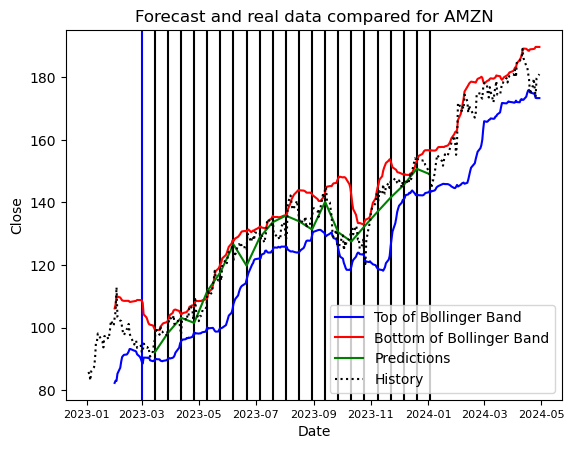

[I 2024-05-25 17:22:27,083] Trial 0 finished with value: 20.534586970107004 and parameters: {'n_a': 36, 'learning_rate': 0.0026938830192854116, 'seq_len': 73, 'dropout': 0.10897663659937938}. Best is trial 0 with value: 20.534586970107004.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0788 - mean_absolute_error: 0.2057 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0746 - mean_absolute_error: 0.1988 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1127 - mean_absolute_error: 0.2499
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0841 - mean_absolute_error: 0.2156
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0867 - mean_absolute_error: 0.2107
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0834 - mean_absolute_error: 0.2167 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0901 - mean_absolute_error: 0.2199
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0795 - mean_absolute_error: 0.2081
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0813 - mean_absolute_error: 0.2095 
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1084 - mean_absolute_error: 0.2594 
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1228 - mean_absolute_error: 0.2641
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1068 - mean_absolute_e

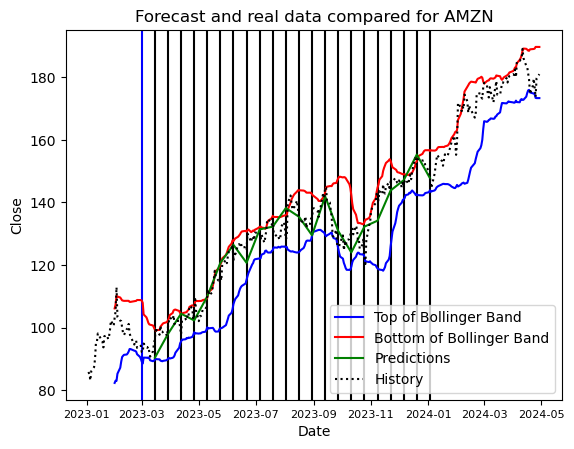

[I 2024-05-25 17:41:41,043] Trial 1 finished with value: 28.11202429432041 and parameters: {'n_a': 28, 'learning_rate': 0.0019578897201213002, 'seq_len': 53, 'dropout': 0.17835460015641597}. Best is trial 0 with value: 20.534586970107004.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0635 - mean_absolute_error: 0.1822
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0665 - mean_absolute_error: 0.1853
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0702 - mean_absolute_error: 0.1955
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0697 - mean_absolute_error: 0.1924
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1961
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0770 - mean_absolute_error: 0.2078
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0788 - mean_absolute_error: 0.2091
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0689 - mean_absolute_error: 0.1929
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0733 - mean_absolute_error: 0.1987
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0677 - mean_absolute_error: 0.1936
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0749 - mean_absolute_error: 0.2010
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0718 - mean_abs

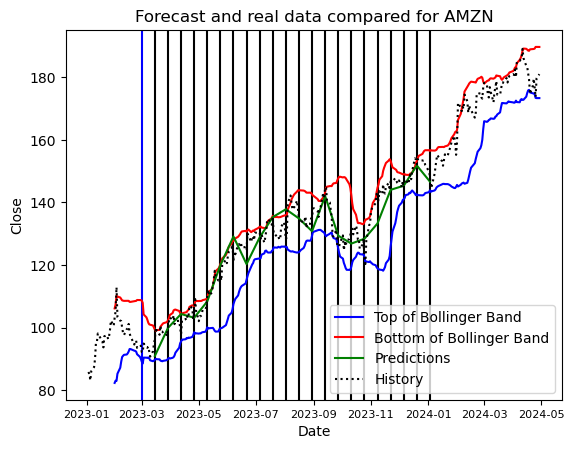

[I 2024-05-25 18:19:01,900] Trial 2 finished with value: 21.987266695729907 and parameters: {'n_a': 62, 'learning_rate': 0.0005846326121643416, 'seq_len': 96, 'dropout': 0.1057789839505809}. Best is trial 0 with value: 20.534586970107004.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0443 - mean_absolute_error: 0.1523  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - mean_absolute_error: 0.1192  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - mean_absolute_error: 0.1269  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0342 - mean_absolute_error: 0.1472  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325 - mean_absolute_error: 0.1346 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - mean_absolute_error: 0.1187 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427 - mean_absolute_error: 0.1559 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0412 - mean_absolute_error: 0.1545  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - mean_absolute_error: 0.1496  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385 - mean_absolute_error: 0.1491  
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340 - mean_absolute_error: 0.1399  
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436 - m

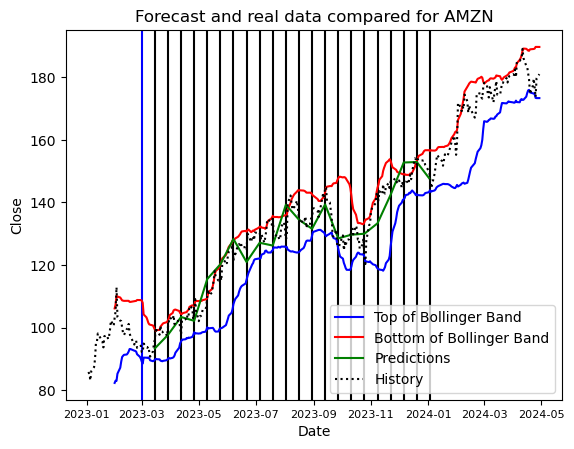

[I 2024-05-25 18:25:28,091] Trial 3 finished with value: 31.708367436289397 and parameters: {'n_a': 37, 'learning_rate': 0.007098936257405904, 'seq_len': 9, 'dropout': 0.017425859940308142}. Best is trial 0 with value: 20.534586970107004.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2998 - mean_absolute_error: 0.4349 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2958 - mean_absolute_error: 0.4271 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2597 - mean_absolute_error: 0.3952 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3051 - mean_absolute_error: 0.4348 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2940 - mean_absolute_error: 0.4265
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2737 - mean_absolute_error: 0.4007 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2850 - mean_absolute_error: 0.4186
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2760 - mean_absolute_error: 0.4121
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3108 - mean_absolute_error: 0.4444 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2869 - mean_absolute_error: 0.4111 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2842 - mean_absolute_error: 0.4207
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2969 - mean_absolute

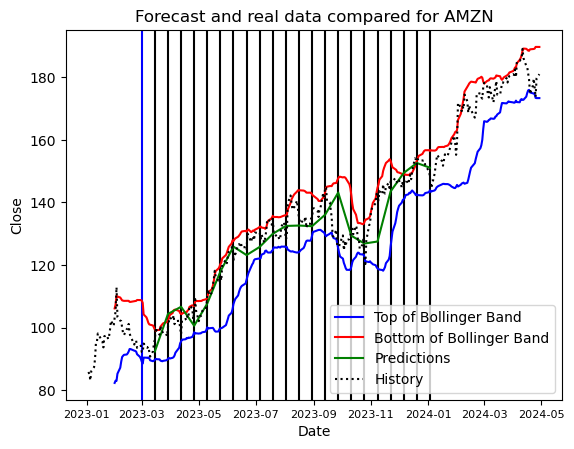

[I 2024-05-25 18:43:05,895] Trial 4 finished with value: 42.723012933213205 and parameters: {'n_a': 2, 'learning_rate': 0.0046263628414755864, 'seq_len': 94, 'dropout': 0.17400242964936385}. Best is trial 0 with value: 20.534586970107004.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0623 - mean_absolute_error: 0.1959
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0504 - mean_absolute_error: 0.1712
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0926 - mean_absolute_error: 0.2284
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0763 - mean_absolute_error: 0.2069
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0641 - mean_absolute_error: 0.1926
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0575 - mean_absolute_error: 0.1767
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0486 - mean_absolute_error: 0.1641
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1006 - mean_absolute_error: 0.2505
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0612 - mean_absolute_error: 0.1858
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0607 - mean_absolute_error: 0.1887
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0569 - mean_absolute_error: 0.1772
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0521 - mean_absolute_error:

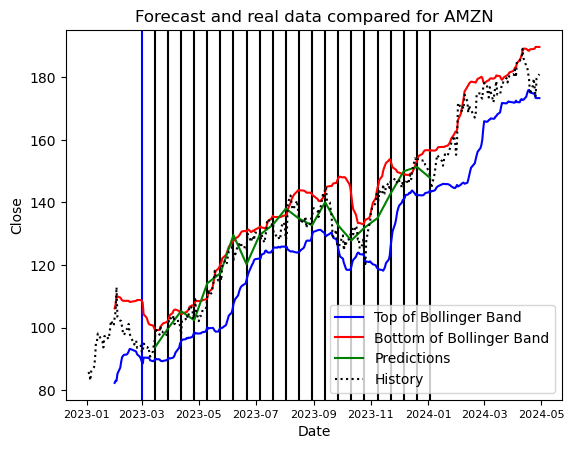

[I 2024-05-25 19:08:51,668] Trial 5 finished with value: 27.296393623947107 and parameters: {'n_a': 63, 'learning_rate': 0.00396567508177101, 'seq_len': 56, 'dropout': 0.1561058352572911}. Best is trial 0 with value: 20.534586970107004.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1776 - mean_absolute_error: 0.3214  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1754 - mean_absolute_error: 0.3234  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1767 - mean_absolute_error: 0.3231 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1620 - mean_absolute_error: 0.3055  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1931 - mean_absolute_error: 0.3436  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1869 - mean_absolute_error: 0.3264  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1870 - mean_absolute_error: 0.3335  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1956 - mean_absolute_error: 0.3370  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1756 - mean_absolute_error: 0.3257  
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1483 - mean_absolute_error: 0.2983  
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1850 - mean_absolute_error: 0.3330 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1991 - 

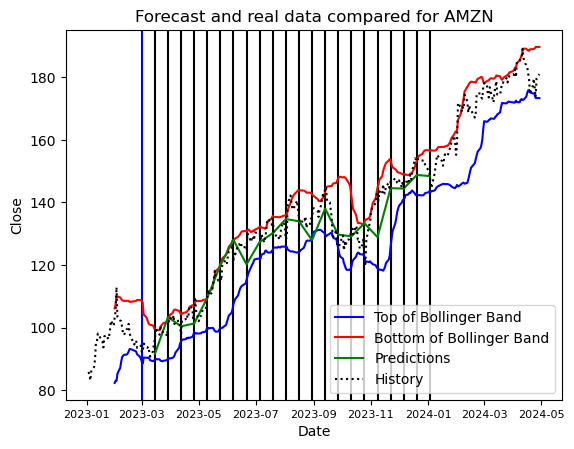

[I 2024-05-25 19:15:49,987] Trial 6 finished with value: 31.396820473025997 and parameters: {'n_a': 8, 'learning_rate': 0.001904767808428205, 'seq_len': 18, 'dropout': 0.1889337834099168}. Best is trial 0 with value: 20.534586970107004.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0905 - mean_absolute_error: 0.2237  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0947 - mean_absolute_error: 0.2249 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1008 - mean_absolute_error: 0.2366  
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0993 - mean_absolute_error: 0.2383  
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0980 - mean_absolute_error: 0.2300 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879 - mean_absolute_error: 0.2191  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0919 - mean_absolute_error: 0.2275  
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0989 - mean_absolute_error: 0.2378 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - mean_absolute_error: 0.2392 
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1072 - mean_absolute_error: 0.2506 
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0935 - mean_absolute_error: 0.2267 
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0971 - mean

In [ ]:
hyperparameter_search = True
num_trials = 50 # If the study already exists, it will be continued with {num_trials} new trials
if hyperparameter_search:
    study_name = f'LSTM_ahead={horizon}'
    storage_name = f'model_tuning_for_{stock_name}'
    # Define the study storage method
    storage = JournalStorage(JournalFileStorage(f"src/tuning/{storage_name}.log"))
    # Pack the arguments
    args = (model_args, data_args, temporal_args, training_args, trading_args)
    # Launch the search
    study = optuna_search(num_trials,
                          storage,
                          study_name,
                          args,
                          na_range = (1, 64),
                          lr_range = (0.0001, 0.01),
                          seq_len_range = (1, 120),
                          dropout_range = (0, 0.2)
                          )

Information about the study's best trial and retrieval of best model hyperparameters

In [ ]:
# Print the best trial, its performance metric and its parameters
best_trial = study.best_trial
print("\nNumber of finished trials: %s"%len(study.trials))
print(f"\nBest trial: {best_trial}")
print("  MSE: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Get the best parameters
model_args['n_a'] = best_trial.params['n_a']
model_args['learning_rate'] = best_trial.params['learning_rate']
model_args['seq_len'] = best_trial.params['seq_len']
model_args['dropout'] = best_trial.params['dropout']

Run the optuna dashboard to visualize the study results

optuna_dashboard.run_server(storage)

Test the tuned model on the test set

test = False
if test:
    ## Set the temporal parameters (Should define the test set)
    start_date = pd.to_datetime('2024-01-01')
    end_date = pd.to_datetime('2024-04-30')
    temporal_args = {'start_date': start_date,
                     'end_date': end_date,
                     'horizon': horizon}
    
    ## Create a forecaster object
    clairvoyant = forecaster(predictor_name,
                             model_args)
    
    ## Create a recommender object
    recommend = recommender(oracle = clairvoyant,
                            trading_args = trading_args)
    
    
    ### Simulate forecasting and recommendations
    recommend(data_args,
              temporal_args,
              training_args) # performs the recommendation